In [1]:
import pandas as pd
import re
import os
import importlib
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display
import warnings
warnings.simplefilter('always')
import numpy as np

import sys

project_root = '/Users/henrybaker/repositories/thesis_analysis'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from scripts.a_data_loading_cleaning import run_load_clean_diagnose_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Loading & Cleaning

In [2]:
csv_path = f"results/grid_results.csv"
df = run_load_clean_diagnose_data(csv_path)

✅ Total generated tokens value is constant: 16384
Original distribution:
total_generated_tokens
16384    3014
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Round 1: Verfifying FLOPs on raw df
NB: FLOPs values are NOT constant: [5.26385823e+13 2.02486233e+13 0.00000000e+00]
Original distribution:
flops
0.000000e+00      20
2.024862e+13     904
5.263858e+13    2090
Name: count, dtype: int64

Dominant FLOPs value: 52638582308864.0
- Affected rows count: 924
- Affected row indices: [1, 2, 4, 5, 6, 8, 10, 15, 17, 19, 21, 22, 24, 26, 27, 29, 31, 32, 33, 34, 36, 38, 39, 41, 46, 48, 50, 56, 57, 64, 67, 69, 71, 74, 75, 77, 83, 86, 90, 91, 92, 93, 94, 96, 97, 99, 101, 104, 105, 106, 107, 110, 114, 115, 120, 121, 122, 123, 128, 129, 131, 132, 135, 139, 141, 145, 147, 150, 151, 159, 160, 165, 166, 168, 170, 171, 172, 175, 176, 181, 182, 183, 184, 186, 188, 189, 190, 191, 193, 194, 195, 197, 204, 207, 211, 212, 213, 21

/Users/henrybaker/repositories/thesis_analysis/scripts/a_data_loading_cleaning.py:611: UserWarning: NB: FLOPs values are NOT constant: [5.26385823e+13 2.02486233e+13 0.00000000e+00]
  if not verify_flops(df):
/Users/henrybaker/repositories/thesis_analysis/scripts/a_data_loading_cleaning.py:621: UserWarning: NB: FLOPs values are NOT constant: [1.69499710e+13 5.26385823e+13]
  verify_flops(df)


In [3]:
# delete duplicates (I messed up running grid search at one point, so need to post hoc remove)

print('before duplicate removal', df.shape[0])

# model-specific config names
df['model_config_name'] = df['model'] + '__' + df['config_name']

# drop duplicates per model-config pair
df = df.drop_duplicates(subset='model_config_name')

print('after duplicate removal', df.shape[0])

assert df['model_config_name'].is_unique, "Duplicate model_config_name values remain!"

before duplicate removal 3014
after duplicate removal 2999


In [4]:
# set up 1b and 3b subsets 
df_1b = df[df['model'].str.contains('1B')]
df_3b = df[df['model'].str.contains('3B')]

In [5]:
# set colours
all_models = sorted(
    set(df['model'])
    | set(df_1b['model'])
    | set(df_3b['model'])
)
n = len(all_models)

# base colormaps
cmap_energy     = cm.get_cmap('Blues')
cmap_throughput = cm.get_cmap('Reds')

# sample only from the mid→dark part of each map
energy_colors     = [cmap_energy(0.5 + 0.5 * i/(n-1)) for i in range(n)]
throughput_colors = [cmap_throughput(0.5 + 0.2 * i/(n-1)) for i in range(n)]

MODEL_COLOURS = {
    m: {
        'energy':     energy_colors[i],
        'throughput': throughput_colors[i]
    }
    for i, m in enumerate(all_models)
}

/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_8025/2703239169.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_energy     = cm.get_cmap('Blues')
/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_8025/2703239169.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_throughput = cm.get_cmap('Reds')


# Exploratory Data Analysis (EDA)

📊 Plotting histogram...


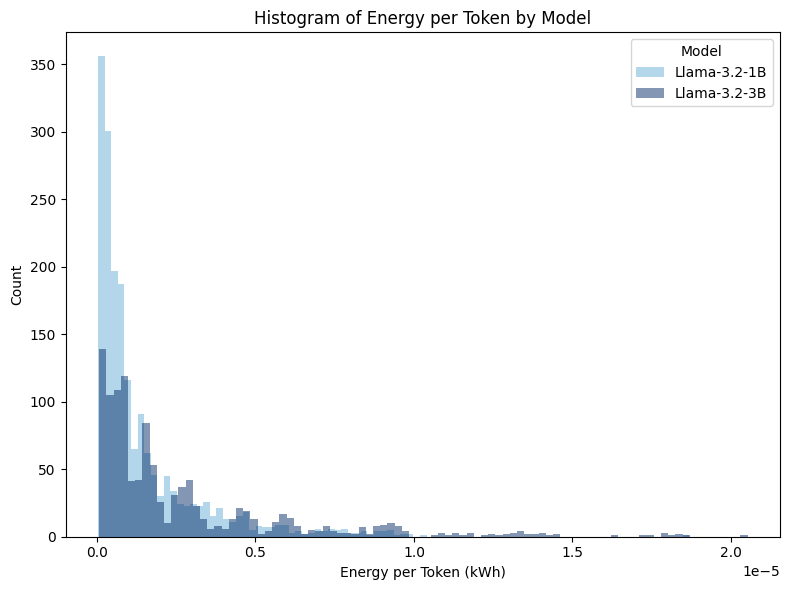

📦 Plotting boxplot...


/Users/henrybaker/repositories/thesis_analysis/scripts/b_exploratory_data_analysis.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, vert=False, patch_artist=True, labels=models)
/Users/henrybaker/repositories/thesis_analysis/scripts/b_exploratory_data_analysis.py:54: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  box = ax.boxplot(data, vert=False, patch_artist=True, labels=models)


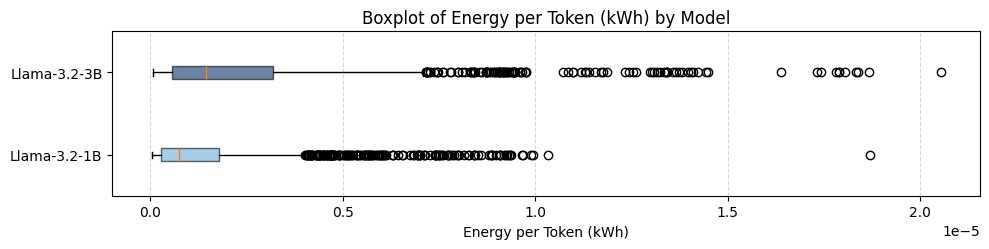

📊 Plotting individual histogram...


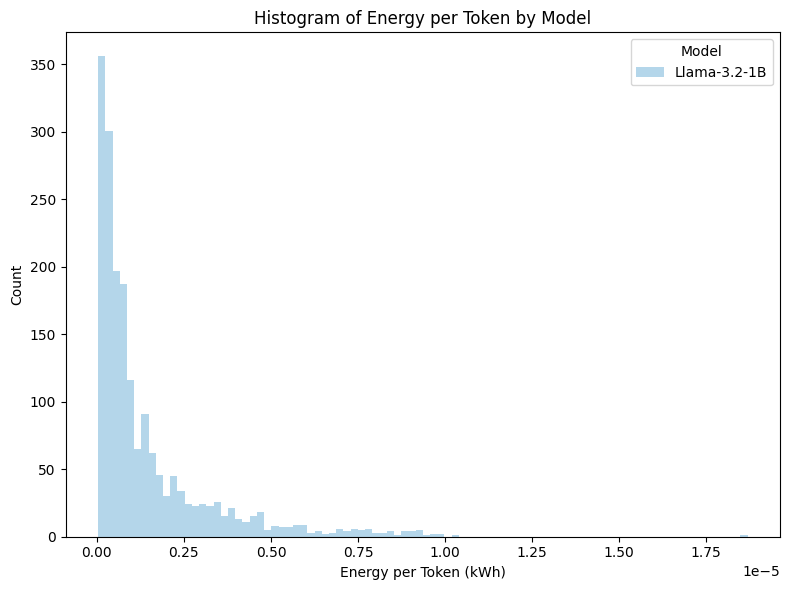

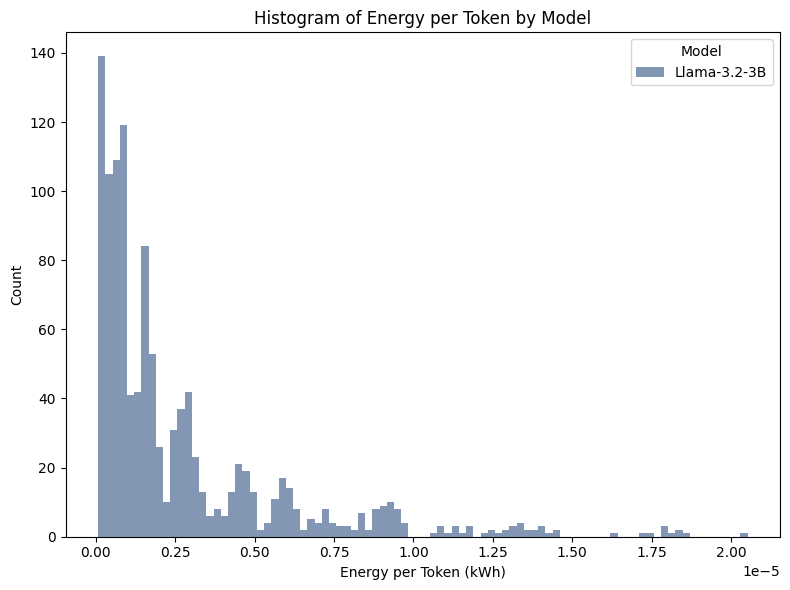

🔬 Scatter: by model...


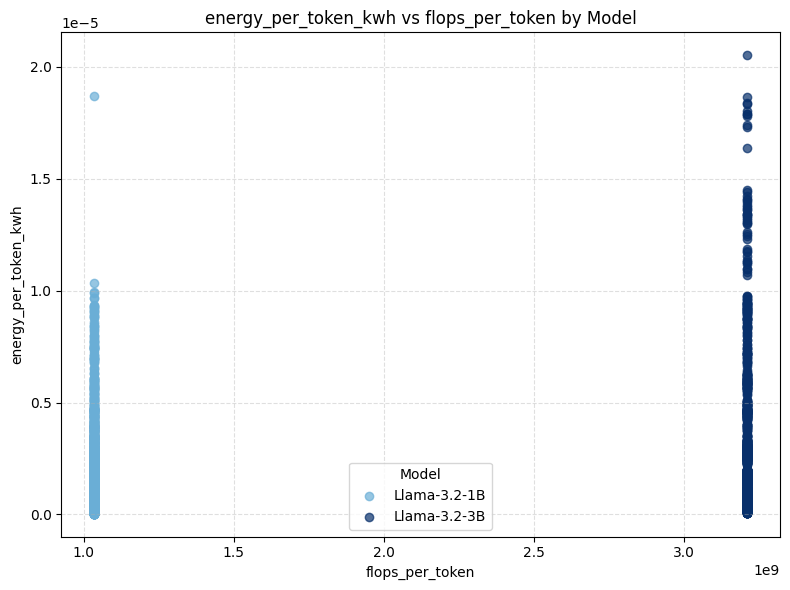

🔗 Correlation matrix...


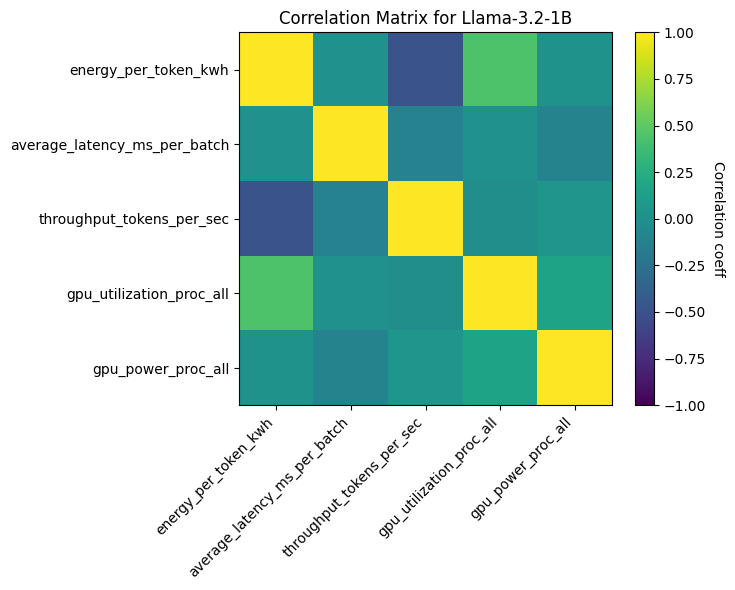

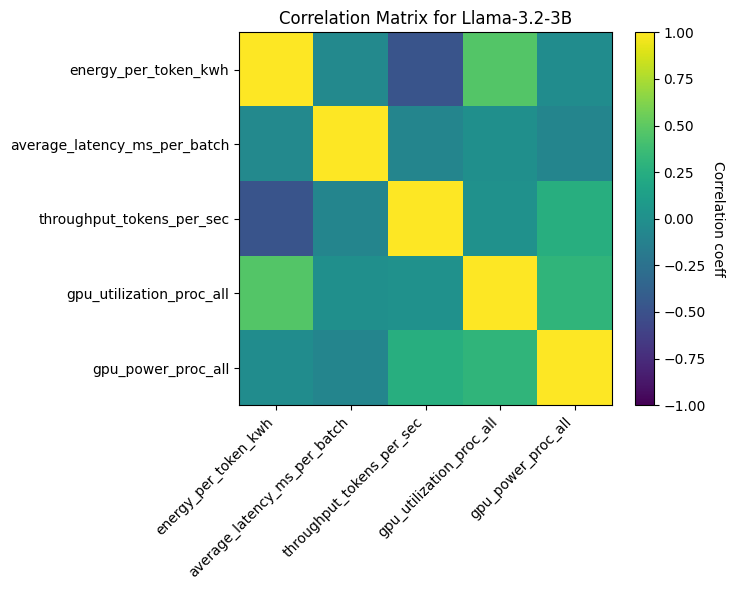

🔬 Scatter: Throughput vs energy...


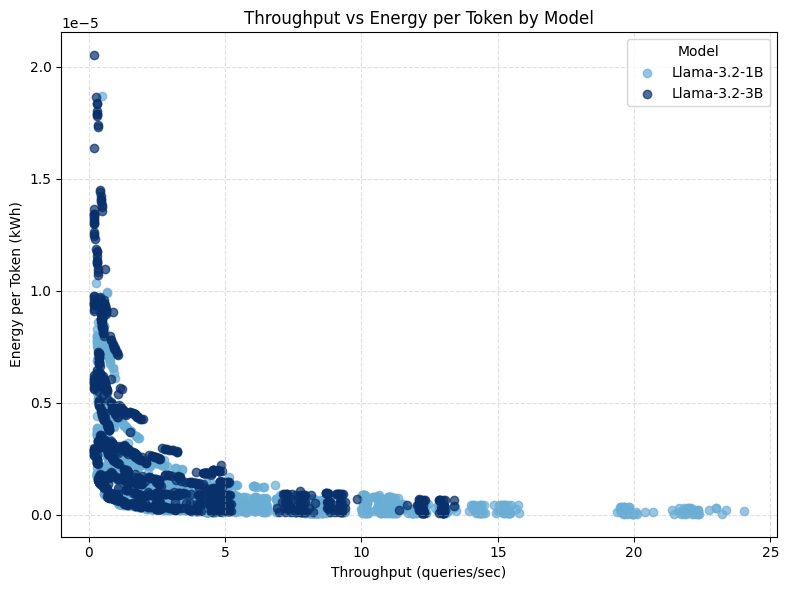

📈 Scatter: Divergence patterns...


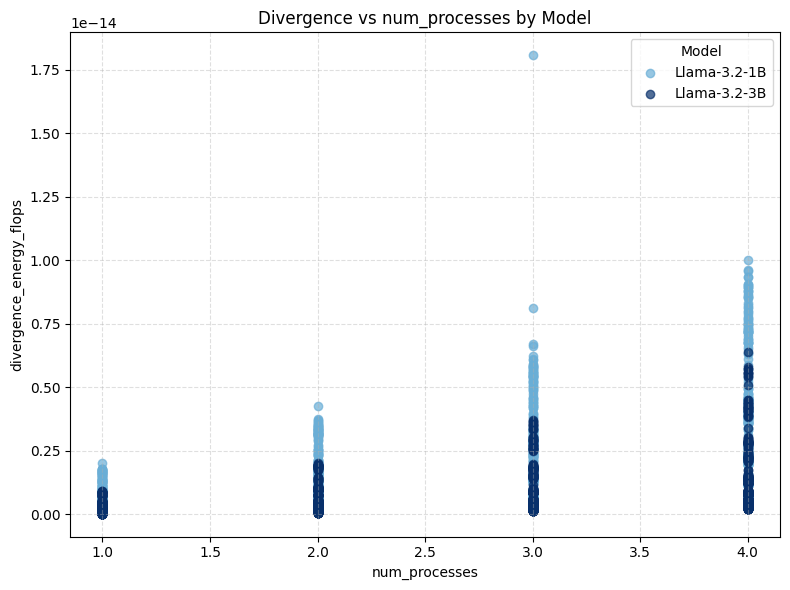

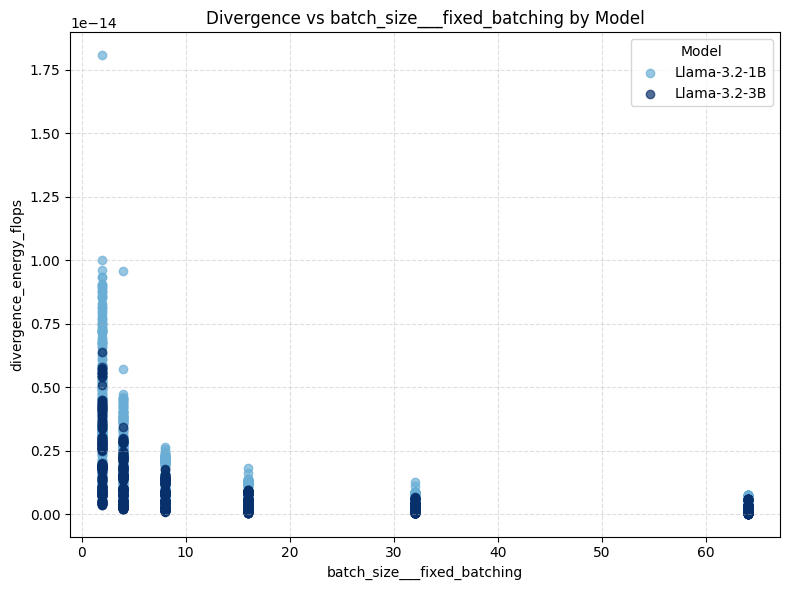

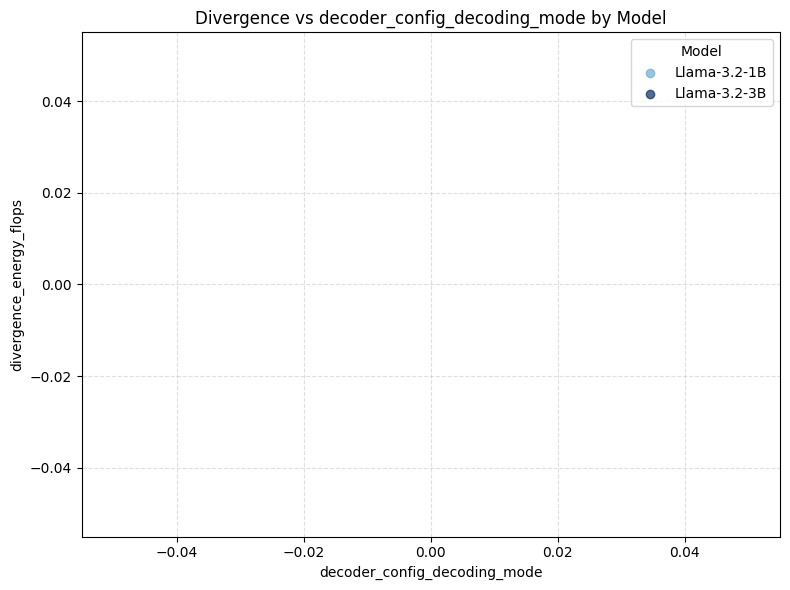

In [6]:
import scripts.b_exploratory_data_analysis as eda
importlib.reload(eda)

eda.plot_all_diagnostics(df, df_1b, df_3b, MODEL_COLOURS)

# Some Data Wrangling

In [7]:
# add precision categories
def _mode(r):
    if r.get('load_in_4bit'):      return 'INT4'
    if r.get('load_in_8bit'):      return 'INT8'
    if r.get('fp_precision')=='torch.float16': return 'FP16'
    return 'FP32'

df['precision'] = pd.Categorical(
    df.apply(_mode, axis=1),
    categories=['FP32','FP16','INT8','INT4'],
    ordered=True
)

# Batching Plots
## Full Grid Search

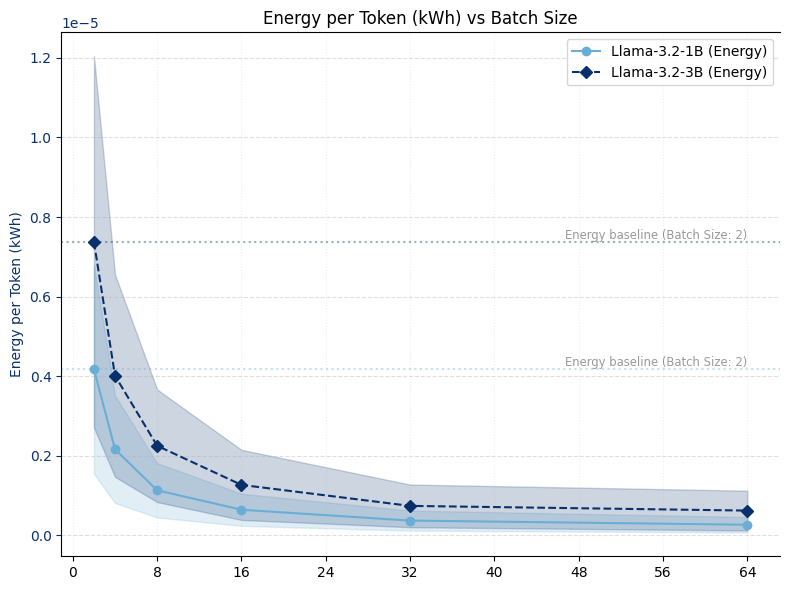

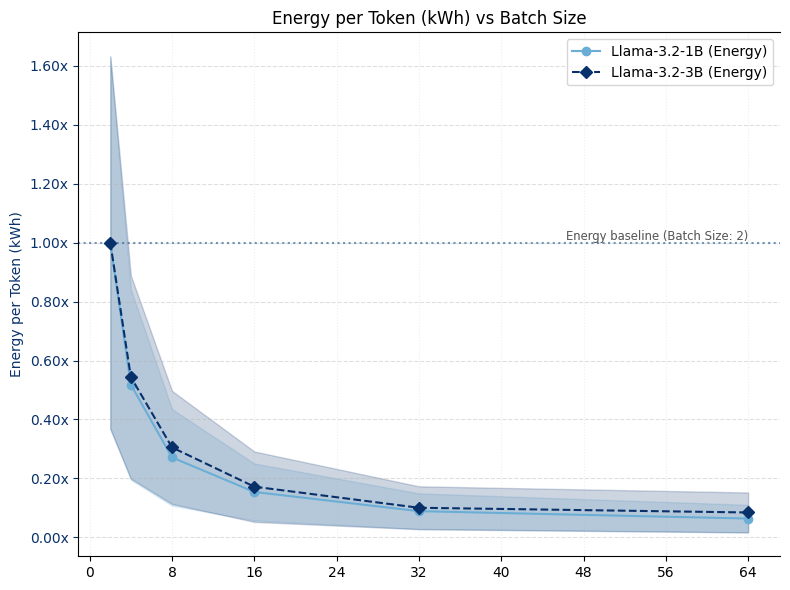

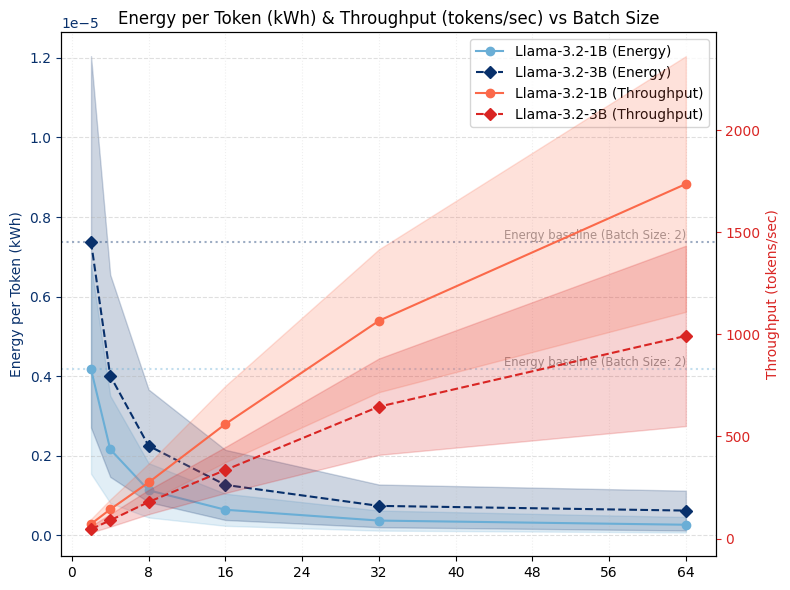

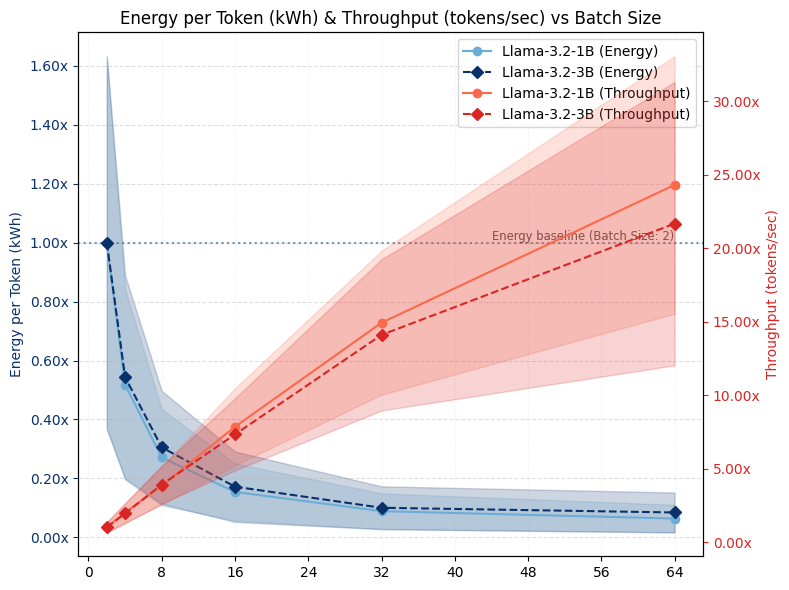

In [8]:
import scripts.c_vis_proc_precis_batch as viz
importlib.reload(viz)

from scripts.c_vis_proc_precis_batch import (
    plot_batching,
)

plot_batching(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
    )

plot_batching(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    normalise_axes=['ax1'],
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
    )

plot_batching(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    ax2='throughput_tokens_per_sec',
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
)

plot_batching(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    ax2='throughput_tokens_per_sec',
    normalise_axes=['ax1', 'ax2'],
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
)



## Subsetted to baseline config

# Tensor Parallelism Plots

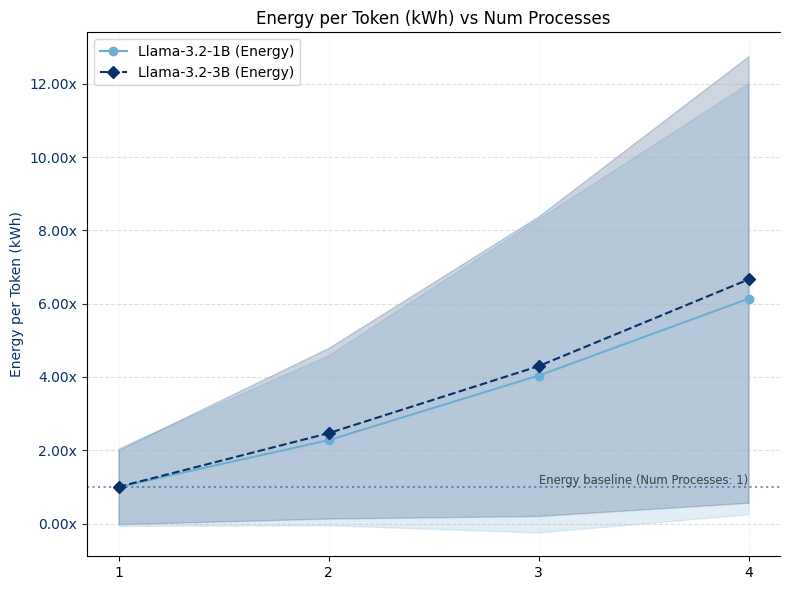

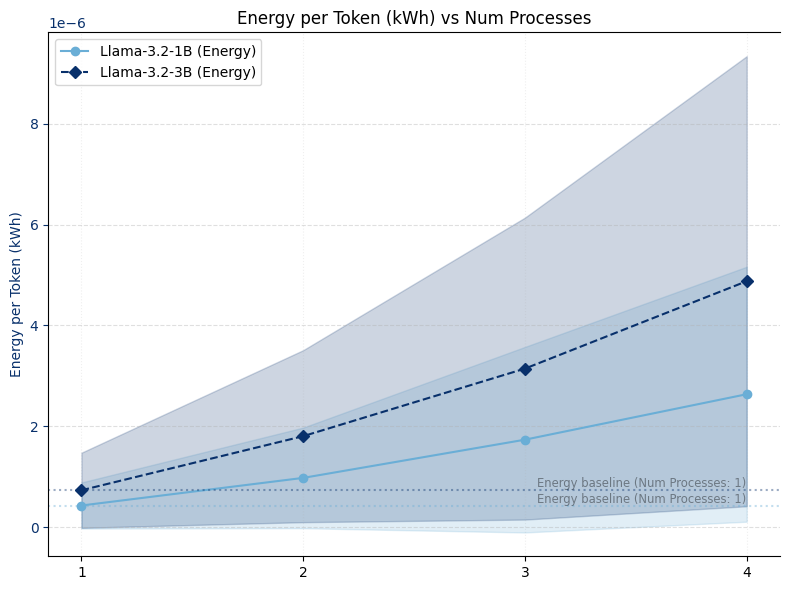

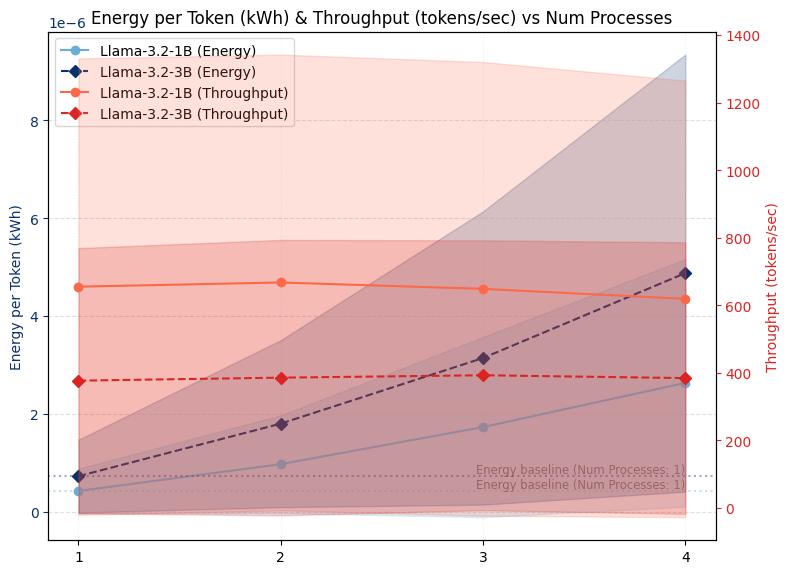

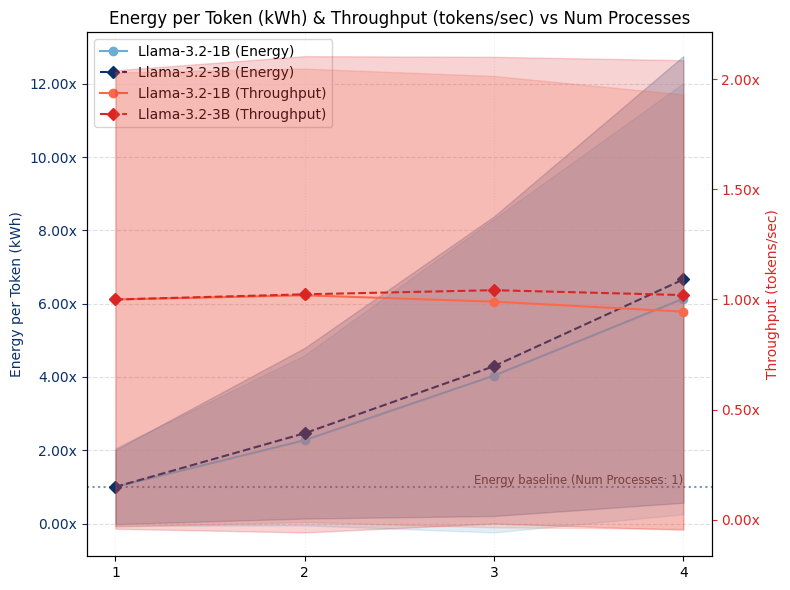

In [9]:
import scripts.c_vis_proc_precis_batch as viz
importlib.reload(viz)

from scripts.c_vis_proc_precis_batch import (
    plot_num_processes,
)

plot_num_processes(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    normalise_axes=['ax1'],
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
)

plot_num_processes(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
)

plot_num_processes(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    ax2='throughput_tokens_per_sec',
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
)

plot_num_processes(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    ax2='throughput_tokens_per_sec',
    normalise_axes=['ax1', 'ax2'],
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
)

# Precision Plots

/Users/henrybaker/repositories/thesis_analysis/scripts/c_vis_proc_precis_batch.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats1 = sub.groupby(param_col)[metric_map[ax1]['col']].agg(['mean','std'])
/Users/henrybaker/repositories/thesis_analysis/scripts/c_vis_proc_precis_batch.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats1 = sub.groupby(param_col)[metric_map[ax1]['col']].agg(['mean','std'])


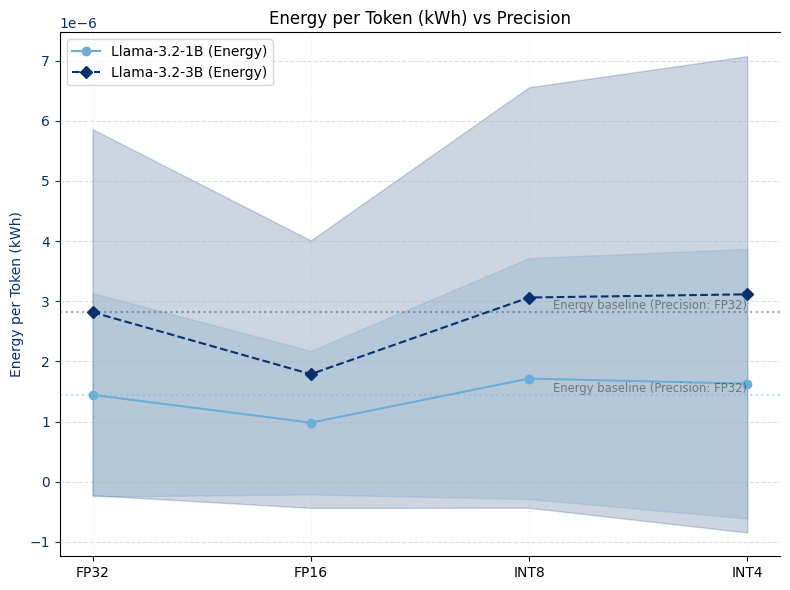

/Users/henrybaker/repositories/thesis_analysis/scripts/c_vis_proc_precis_batch.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats1 = sub.groupby(param_col)[metric_map[ax1]['col']].agg(['mean','std'])
/Users/henrybaker/repositories/thesis_analysis/scripts/c_vis_proc_precis_batch.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats1 = sub.groupby(param_col)[metric_map[ax1]['col']].agg(['mean','std'])


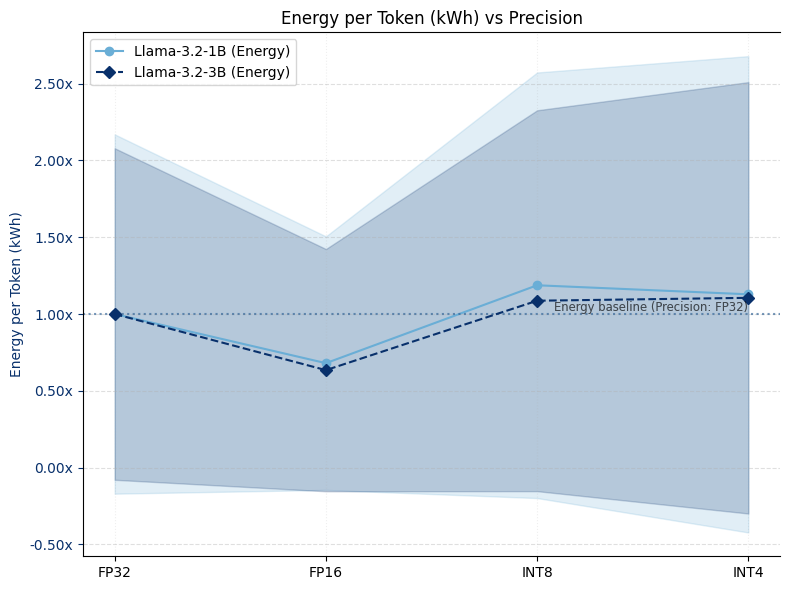

/Users/henrybaker/repositories/thesis_analysis/scripts/c_vis_proc_precis_batch.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats1 = sub.groupby(param_col)[metric_map[ax1]['col']].agg(['mean','std'])
/Users/henrybaker/repositories/thesis_analysis/scripts/c_vis_proc_precis_batch.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats2 = sub.groupby(param_col)[metric_map[ax2]['col']].agg(['mean','std'])
/Users/henrybaker/repositories/thesis_analysis/scripts/c_vis_proc_precis_batch.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p

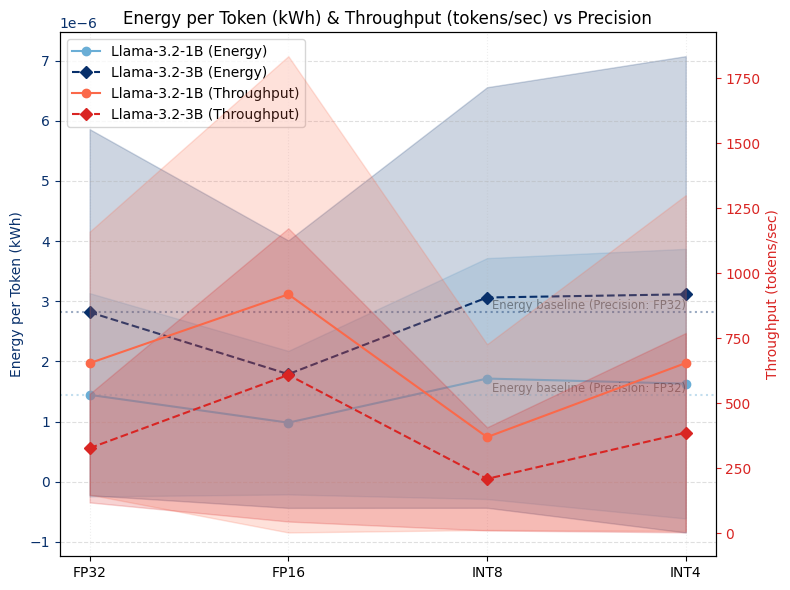

/Users/henrybaker/repositories/thesis_analysis/scripts/c_vis_proc_precis_batch.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats1 = sub.groupby(param_col)[metric_map[ax1]['col']].agg(['mean','std'])
/Users/henrybaker/repositories/thesis_analysis/scripts/c_vis_proc_precis_batch.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats2 = sub.groupby(param_col)[metric_map[ax2]['col']].agg(['mean','std'])
/Users/henrybaker/repositories/thesis_analysis/scripts/c_vis_proc_precis_batch.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p

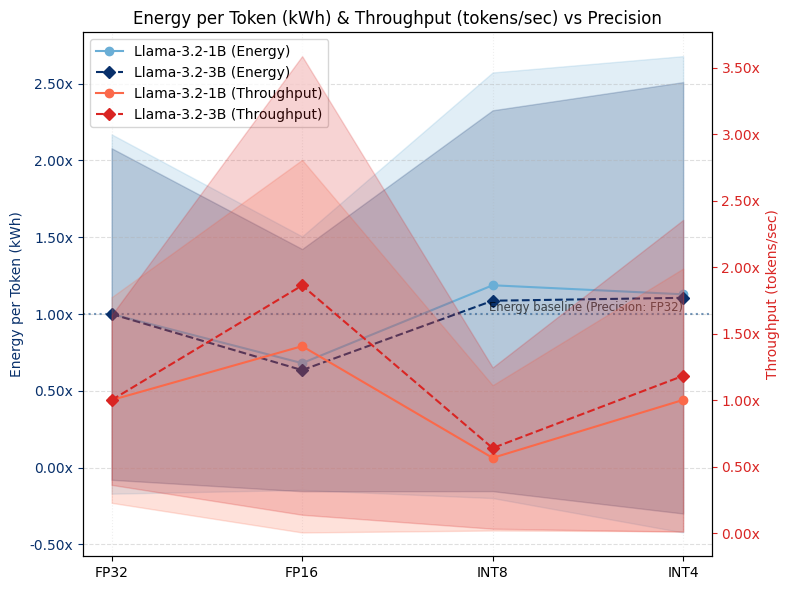

In [10]:
import scripts.c_vis_proc_precis_batch as viz
importlib.reload(viz)

from scripts.c_vis_proc_precis_batch import (
    plot_precision,
)

plot_precision(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
)
plot_precision(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    normalise_axes=['ax1'],
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
)

plot_precision(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    ax2='throughput_tokens_per_sec',
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
)

plot_precision(
    df,
    MODEL_COLOURS,
    ax1='energy_per_token',
    ax2='throughput_tokens_per_sec',
    normalise_axes=['ax1', 'ax2'],
    plot_mean=True,
    plot_band=True,
    plot_raw=False,
    add_baseline_energy=True,
    add_baseline_throughput=False
)

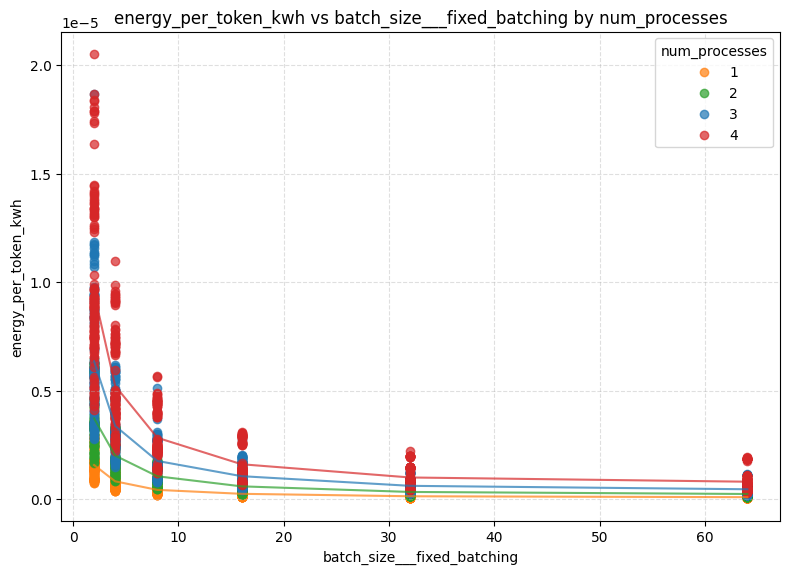

/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_8025/646297697.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for grp, subset in df.groupby(group):


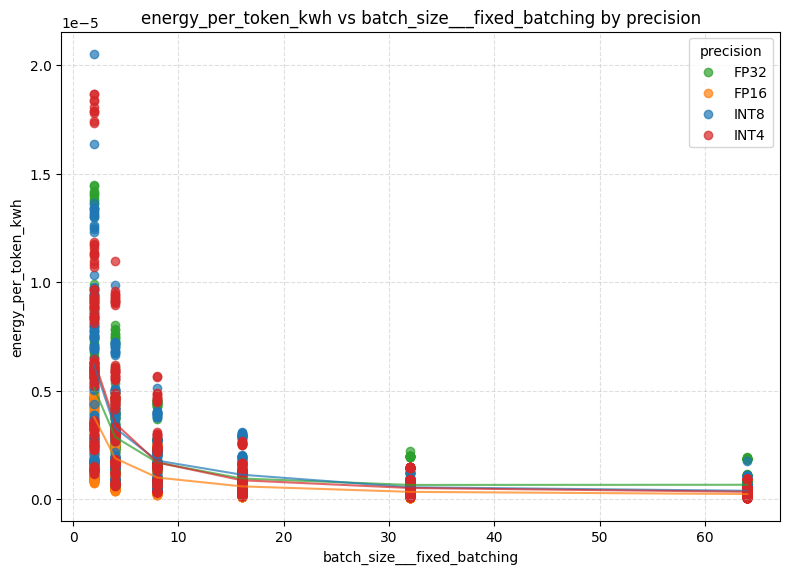

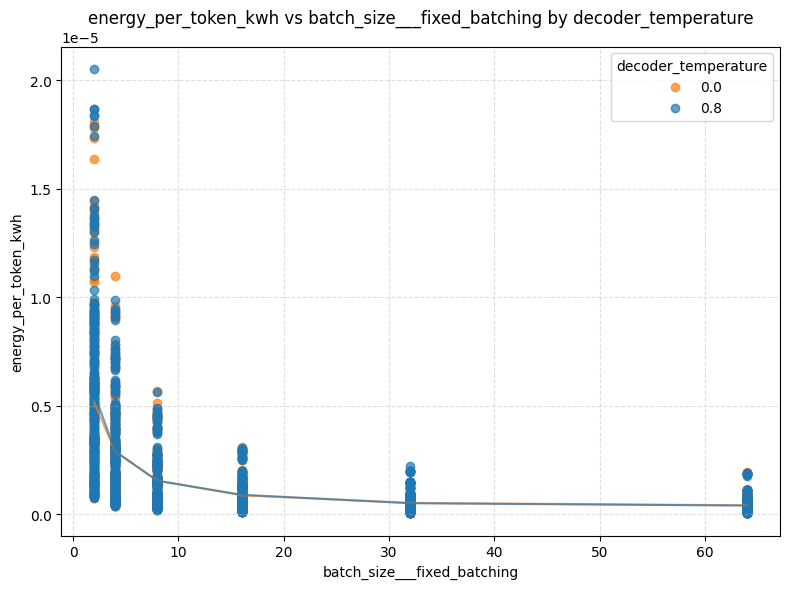

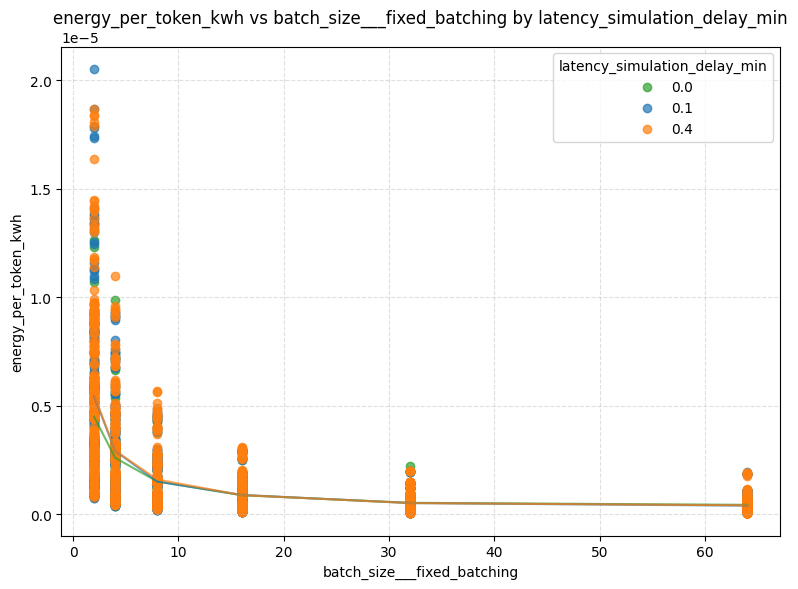

In [11]:
import matplotlib.pyplot as plt

def plot_x_vs_y_by_group(df, x, y, group):
    '''
    Scatter and mean line plot of y vs x for each group in the dataframe.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    x (str): Column name to use for the x-axis.
    y (str): Column name to use for the y-axis.
    group (str): Column name to group data by.
    '''
    # Identify unique groups and assign colors
    unique_groups = df[group].unique()
    cmap = plt.get_cmap('tab10')
    color_map = {grp: cmap(i % cmap.N) for i, grp in enumerate(unique_groups)}

    plt.figure(figsize=(8, 6))
    for grp, subset in df.groupby(group):
        # Scatter points
        plt.scatter(subset[x], subset[y],
                    alpha=0.7, label=str(grp), color=color_map[grp])
        # Compute and plot mean line
        mean_df = subset.groupby(x)[y].mean().reset_index()
        plt.plot(mean_df[x], mean_df[y],
                 alpha=0.7, color=color_map[grp])

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{y} vs {x} by {group}")
    plt.legend(title=group)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_x_vs_y_by_group(df, x='batch_size___fixed_batching', y='energy_per_token_kwh', group='num_processes')
plot_x_vs_y_by_group(df, x='batch_size___fixed_batching', y='energy_per_token_kwh', group='precision')
plot_x_vs_y_by_group(df, x='batch_size___fixed_batching', y='energy_per_token_kwh', group='decoder_temperature')
plot_x_vs_y_by_group(df, x='batch_size___fixed_batching', y='energy_per_token_kwh', group='latency_simulation_delay_min')

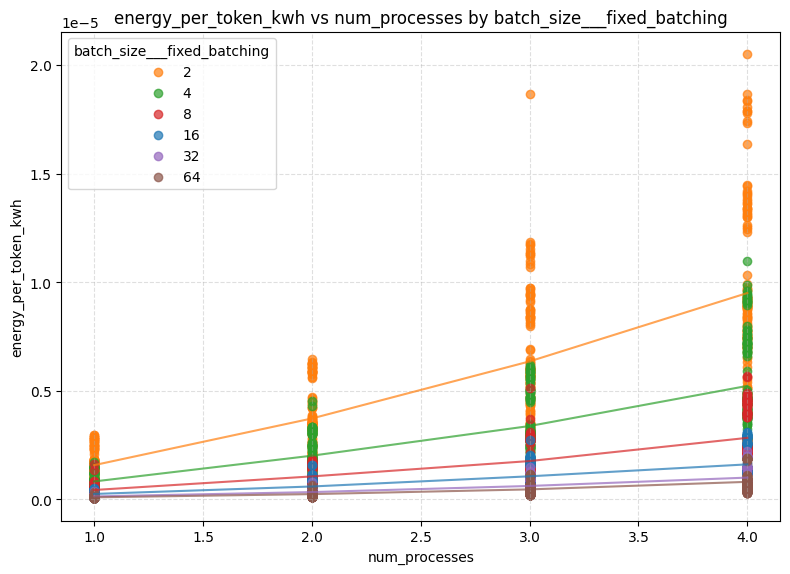

/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_8025/646297697.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for grp, subset in df.groupby(group):


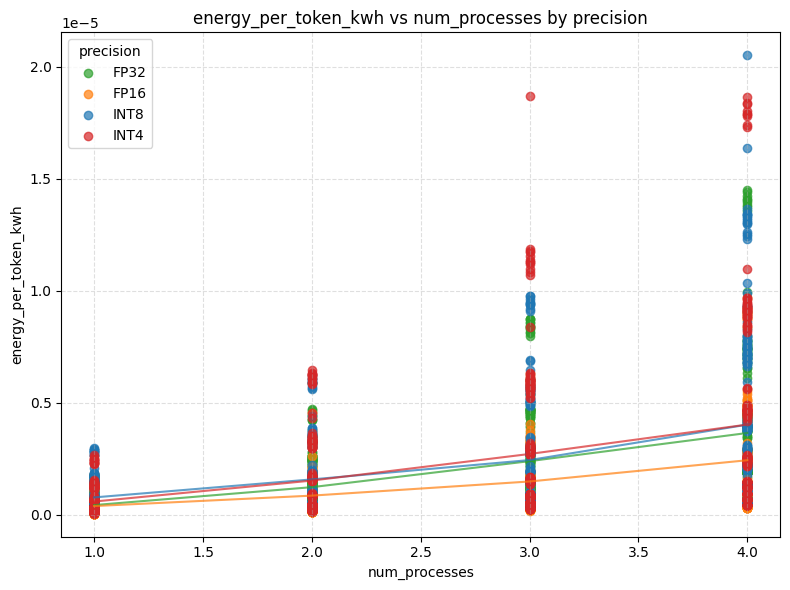

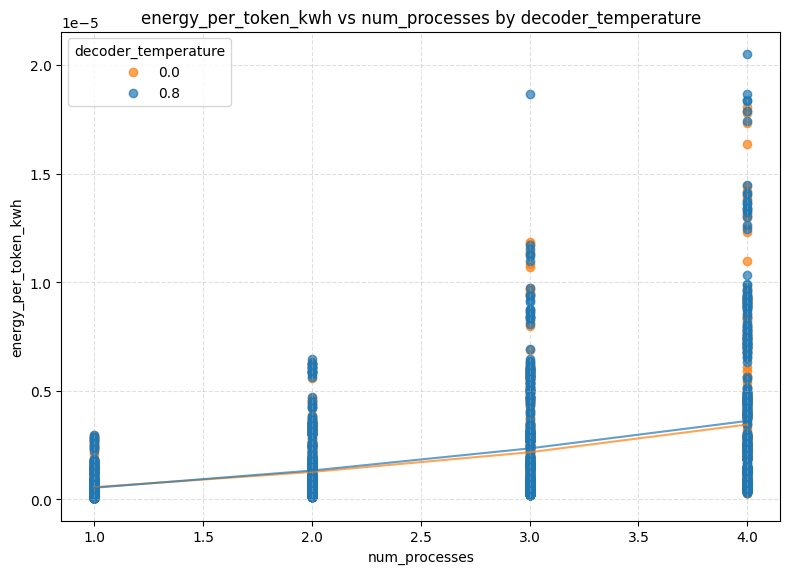

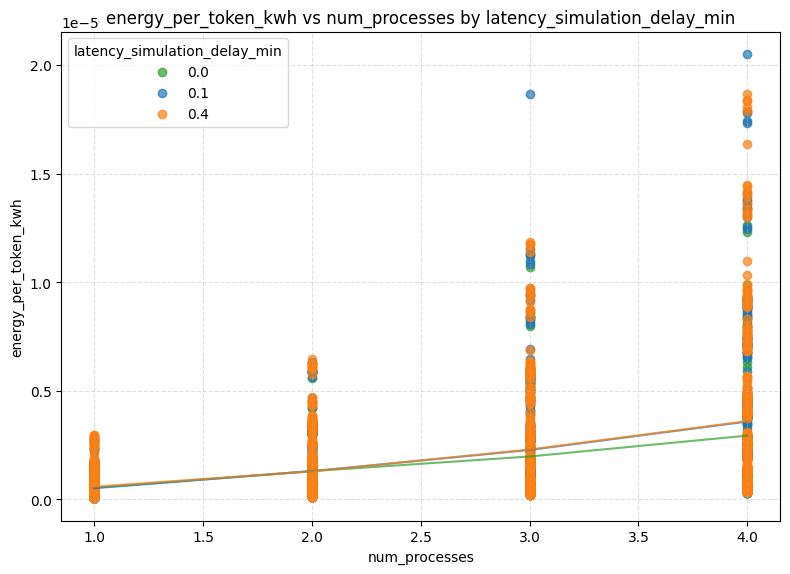

In [12]:
plot_x_vs_y_by_group(df, x='num_processes', y='energy_per_token_kwh', group='batch_size___fixed_batching')
plot_x_vs_y_by_group(df, x='num_processes', y='energy_per_token_kwh', group='precision')
plot_x_vs_y_by_group(df, x='num_processes', y='energy_per_token_kwh', group='decoder_temperature')
plot_x_vs_y_by_group(df, x='num_processes', y='energy_per_token_kwh', group='latency_simulation_delay_min')

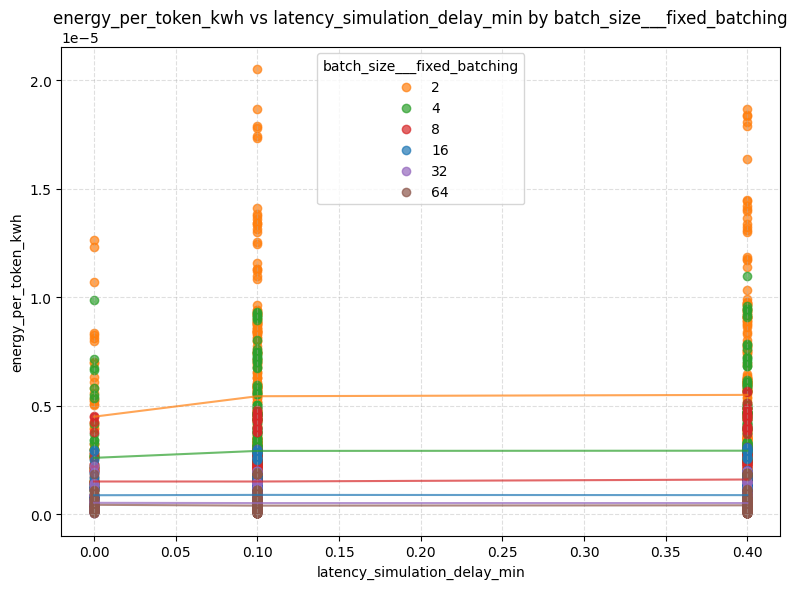

In [13]:
plot_x_vs_y_by_group(df, x='latency_simulation_delay_min', y='energy_per_token_kwh', group='batch_size___fixed_batching')


/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_8025/646297697.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = subset.groupby(x)[y].mean().reset_index()
/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_8025/646297697.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = subset.groupby(x)[y].mean().reset_index()
/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_8025/646297697.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

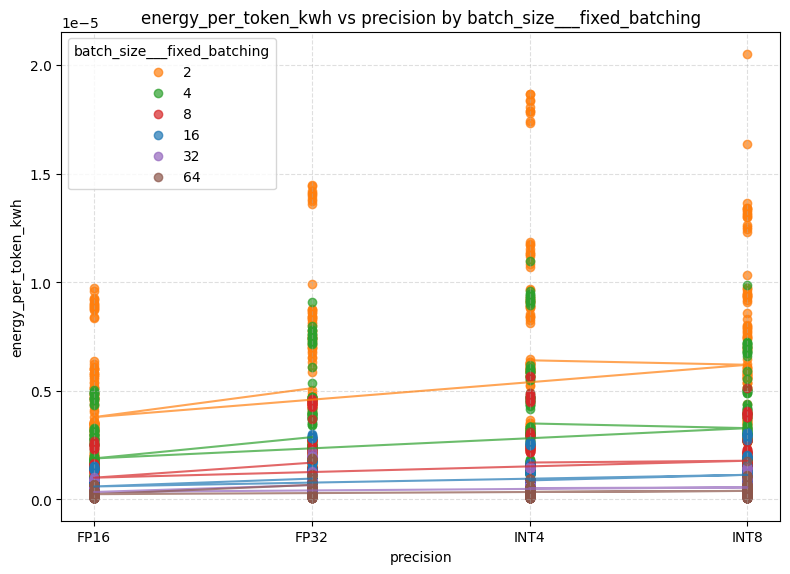

/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_8025/646297697.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for grp, subset in df.groupby(group):


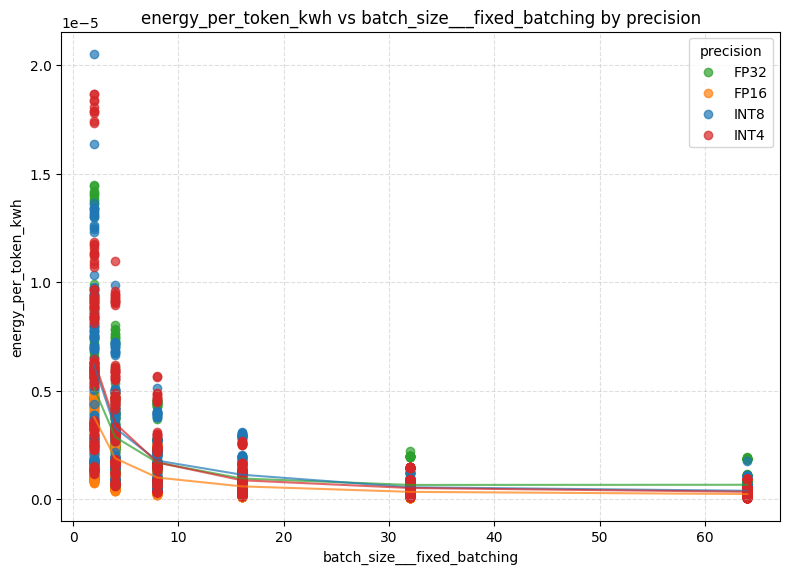

In [14]:
plot_x_vs_y_by_group(df, x='precision', y='energy_per_token_kwh', group='batch_size___fixed_batching')
plot_x_vs_y_by_group(df, x='batch_size___fixed_batching', y='energy_per_token_kwh', group='precision')

<Axes: xlabel='precision', ylabel='energy_per_token_kwh'>

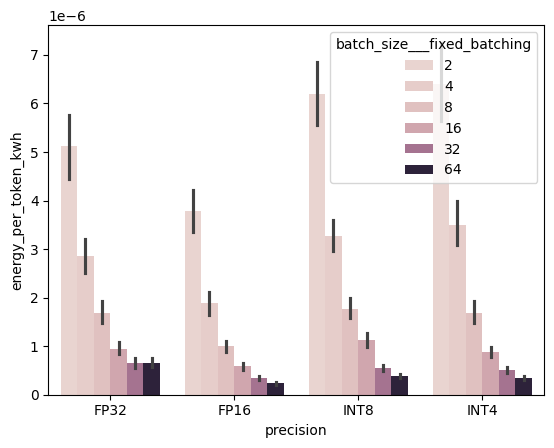

In [15]:
import seaborn as sns

sns.barplot(
    data=df,
    x='precision',
    y='energy_per_token_kwh',
    hue='batch_size___fixed_batching',
    order=['FP32', 'FP16', 'INT8', 'INT4'],      # ← tell it exactly which order to use
)

/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_8025/646297697.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for grp, subset in df.groupby(group):


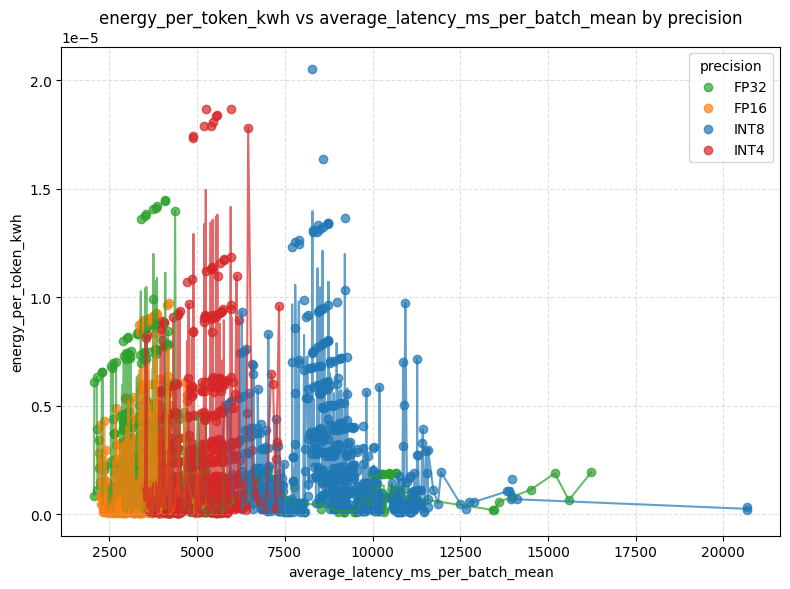

In [16]:
plot_x_vs_y_by_group(df, x='average_latency_ms_per_batch_mean', y='energy_per_token_kwh', group='precision')

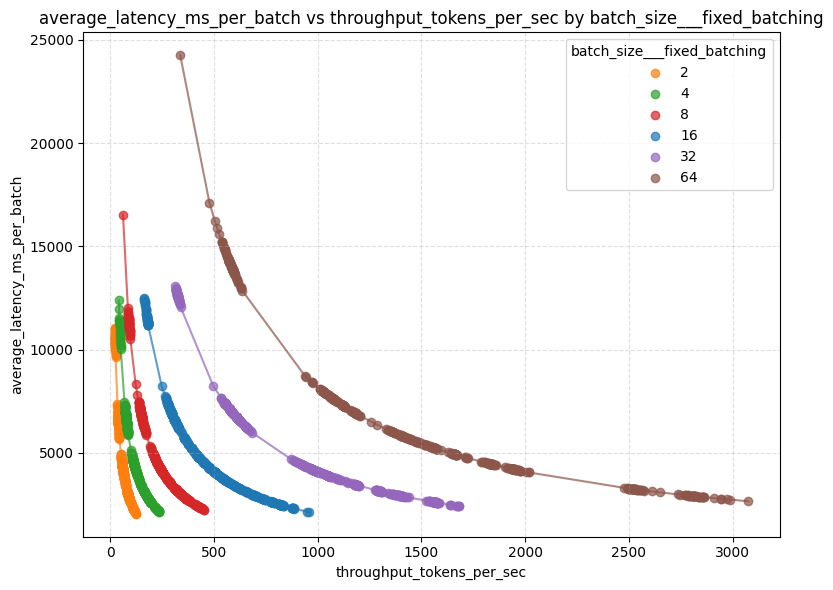

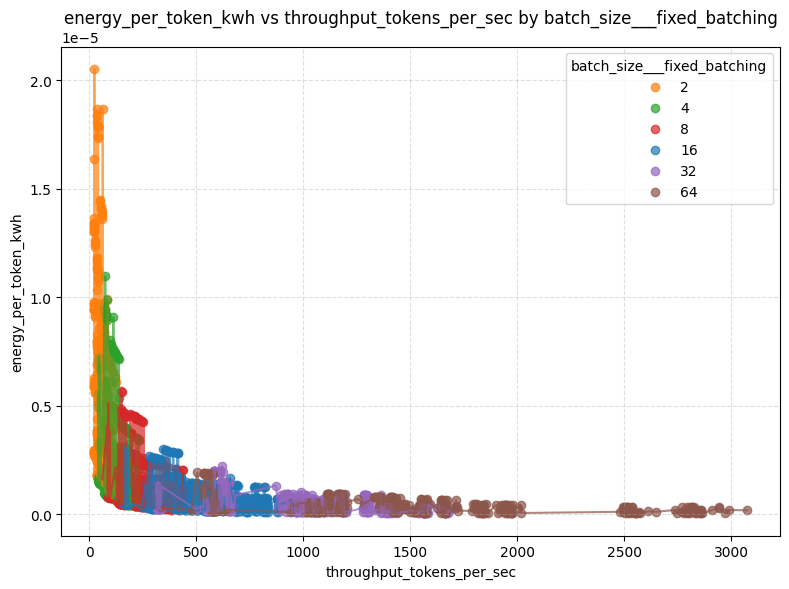

In [17]:
plot_x_vs_y_by_group(df, x='throughput_tokens_per_sec', y='average_latency_ms_per_batch', group='batch_size___fixed_batching')
plot_x_vs_y_by_group(df, x='throughput_tokens_per_sec', y='energy_per_token_kwh', group='batch_size___fixed_batching')


In [18]:
df.columns[df.columns.str.contains('latency')]

Index(['latency_simulation_simulate', 'latency_simulation_delay_max',
       'latency_simulation_delay_min', 'latency_simulation_simulate_burst',
       'latency_simulation_burst_size', 'latency_simulation_burst_interval',
       'average_latency_ms_per_batch', 'average_latency_ms_per_batch_mean',
       'average_latency_ms_per_batch_std'],
      dtype='object')

ANOVA table:
                                                  sum_sq      df            F  \
num_processes                              3.647472e-09     1.0  1022.096975   
batch_size___fixed_batching                4.116005e-09     1.0  1153.389716   
num_processes:batch_size___fixed_batching  1.223025e-09     1.0   342.716955   
Residual                                   1.068801e-08  2995.0          NaN   

                                                  PR(>F)  
num_processes                              3.206614e-193  
batch_size___fixed_batching                3.723104e-214  
num_processes:batch_size___fixed_batching   1.567905e-72  
Residual                                             NaN  


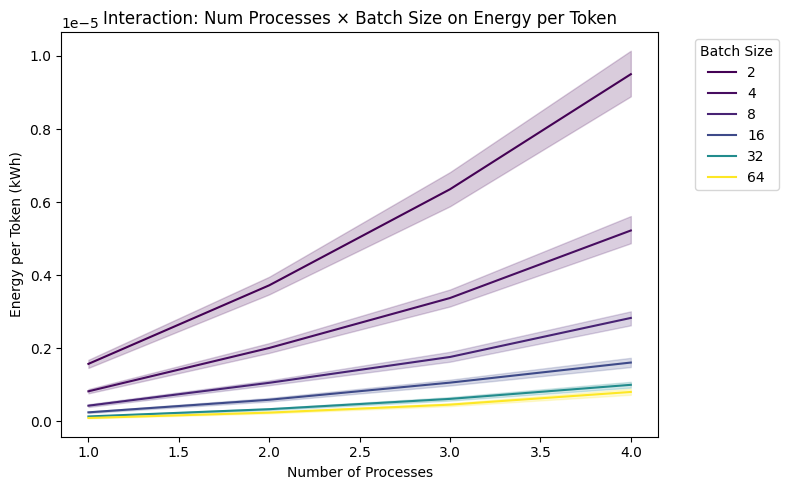

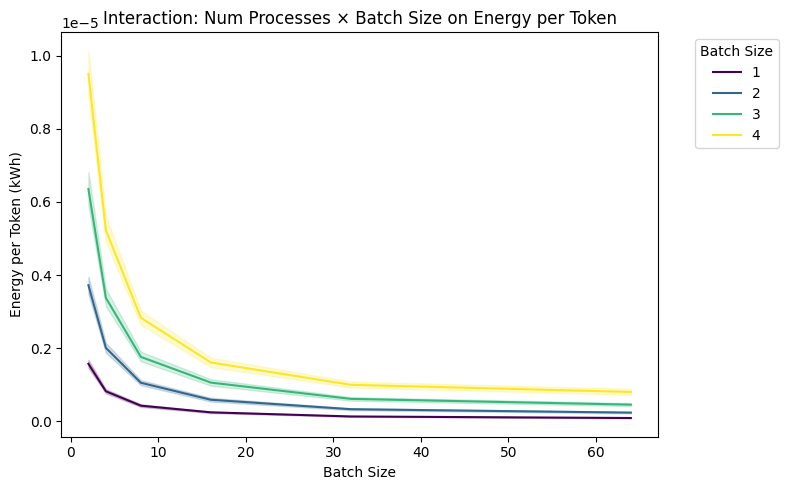

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Ensure types are categorical where appropriate
df['num_processes'] = df['num_processes'].astype(int)
df['batch_size___fixed_batching'] = df['batch_size___fixed_batching'].astype(int)

## 2. Fit interaction model (numeric factors)
model = smf.ols(
    'energy_per_token_kwh ~ num_processes * batch_size___fixed_batching',
    data=df
).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA table:\n", anova_table)

# 3. Visualise with lineplot
plt.figure(figsize=(8,5))
sns.lineplot(
    data=df,
    x='num_processes',
    y='energy_per_token_kwh',
    hue='batch_size___fixed_batching',
    estimator='mean',
    errorbar=('ci', 95),
    palette='viridis',
    legend='full'
)
plt.title('Interaction: Num Processes × Batch Size on Energy per Token')
plt.xlabel('Number of Processes')
plt.ylabel('Energy per Token (kWh)')
plt.legend(title='Batch Size', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(
    data=df,
    x='batch_size___fixed_batching',
    y='energy_per_token_kwh',
    hue='num_processes',
    estimator='mean',
    errorbar=('ci', 95),
    palette='viridis',
    legend='full'
)
plt.title('Interaction: Num Processes × Batch Size on Energy per Token')
plt.xlabel('Batch Size')
plt.ylabel('Energy per Token (kWh)')
plt.legend(title='Batch Size', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()



# Batching Plots

# Precision Plots

# Decoder Plots

/Users/henrybaker/repositories/thesis_analysis/scripts/d_vis_decoder.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


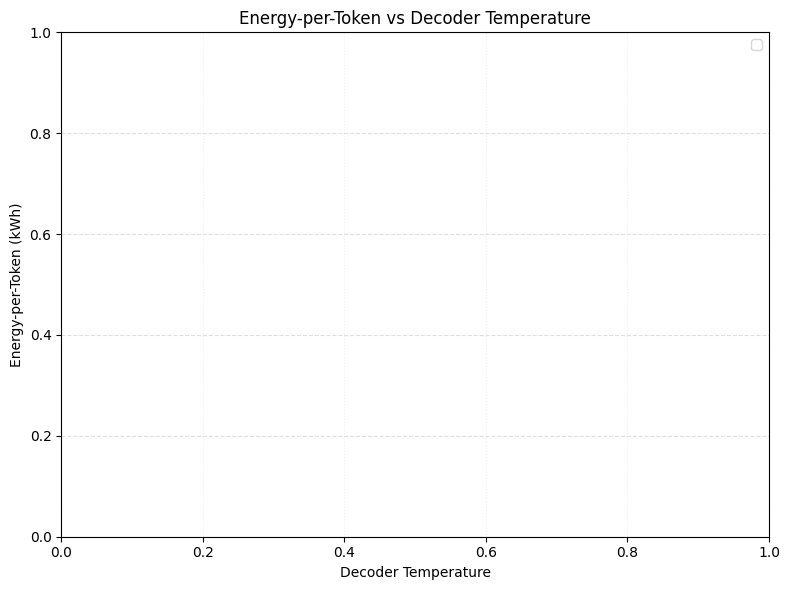

/Users/henrybaker/repositories/thesis_analysis/scripts/d_vis_decoder.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


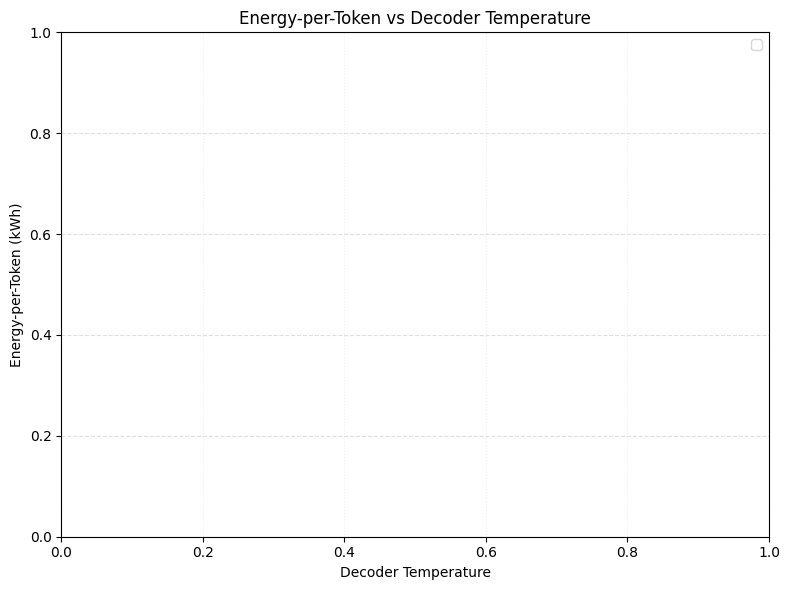

/Users/henrybaker/repositories/thesis_analysis/scripts/d_vis_decoder.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


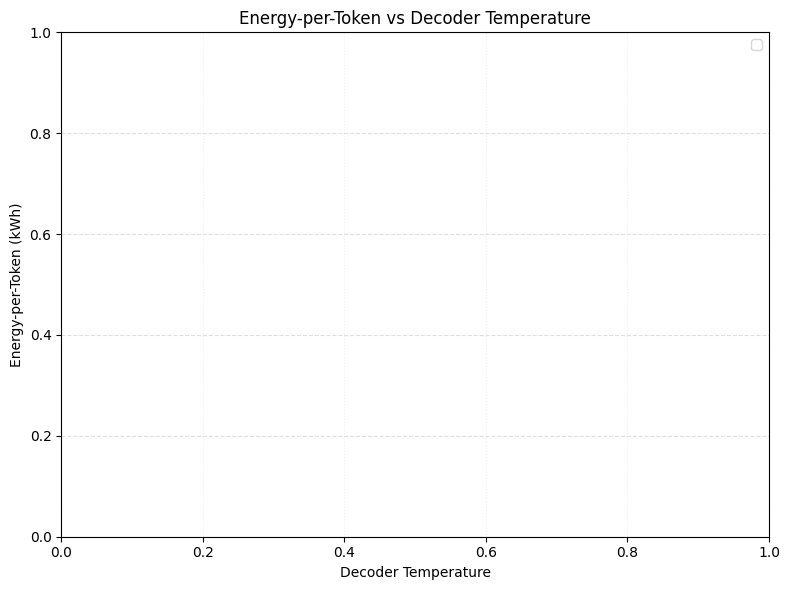

In [20]:
import scripts.d_vis_decoder as viz_decoder
importlib.reload(viz_decoder)

from scripts.d_vis_decoder import plot_decoder_temperature

plot_decoder_temperature(
    dfs=df,
    model=['Llama-3.2-1B', 'Llama-3.2-3B'],
    normalise_axes=[],
    plot_mean=True,
    plot_band=False,
    plot_raw=False,
    add_baseline_energy=True,
    cycle_id=None
    )

plot_decoder_temperature(
    dfs=df,
    model=['Llama-3.2-1B'],
    normalise_axes=[],
    plot_mean=True,
    plot_band=False,
    plot_raw=False,
    add_baseline_energy=True,
    cycle_id=None
    )

plot_decoder_temperature(
    dfs=df,
    model=['Llama-3.2-3B'],
    normalise_axes=[],
    plot_mean=True,
    plot_band=False,
    plot_raw=False,
    add_baseline_energy=True,
    cycle_id=None
    )


/Users/henrybaker/repositories/thesis_analysis/scripts/d_vis_decoder.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


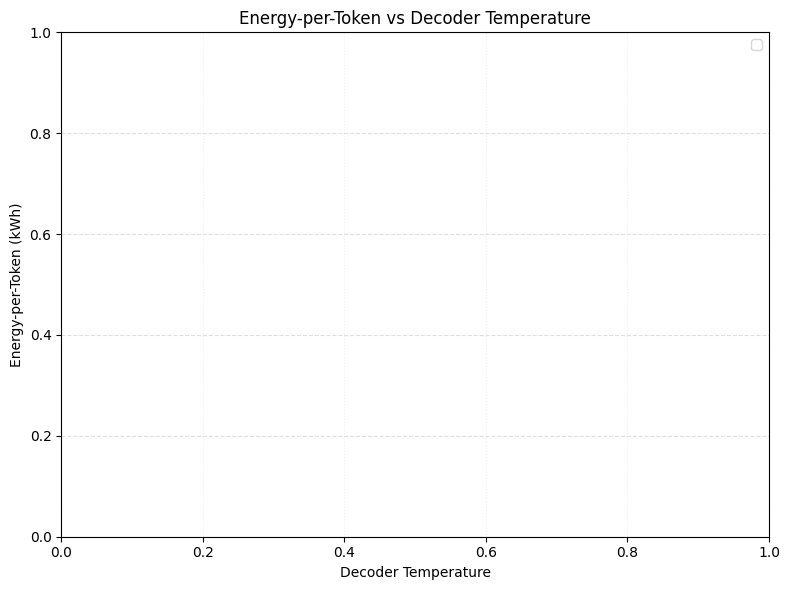

/Users/henrybaker/repositories/thesis_analysis/scripts/d_vis_decoder.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


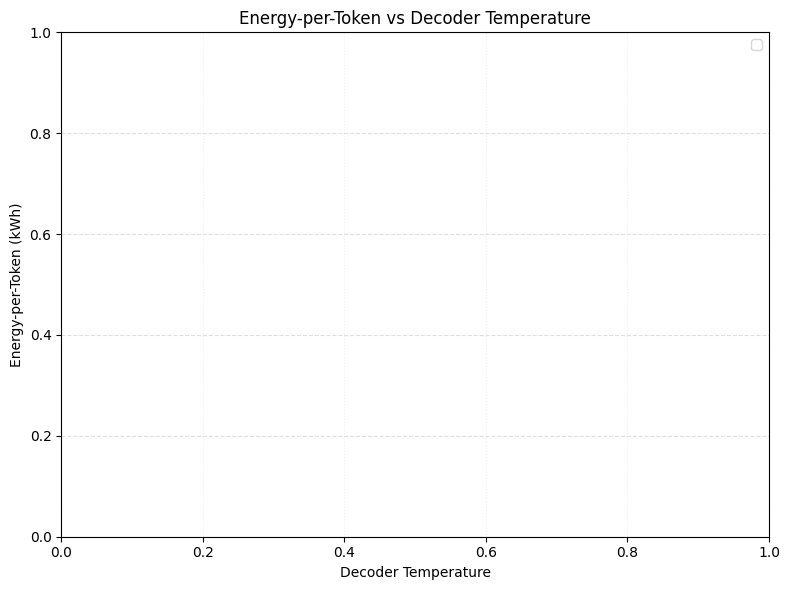

/Users/henrybaker/repositories/thesis_analysis/scripts/d_vis_decoder.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


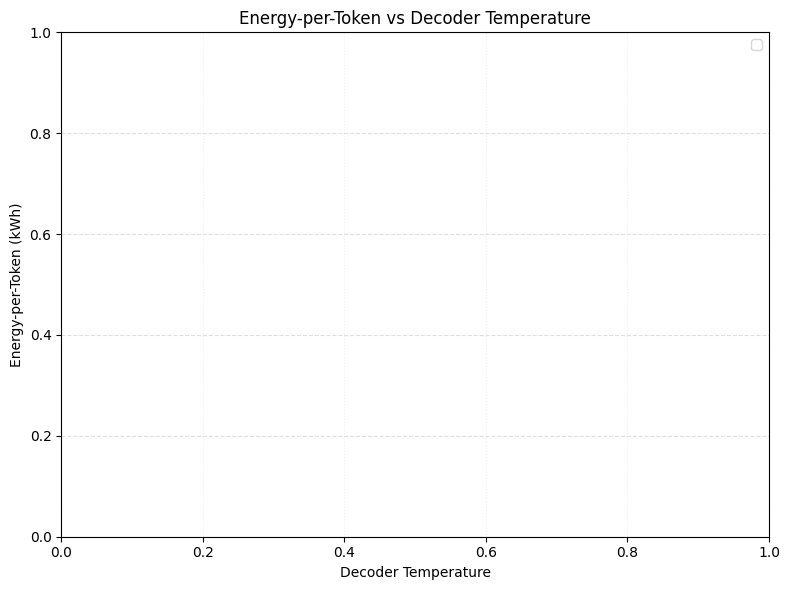

In [21]:
import scripts.d_vis_decoder as viz_decoder
importlib.reload(viz_decoder)

from scripts.d_vis_decoder import plot_decoder_temperature

plot_decoder_temperature(
    dfs=df,
    model=['Llama-3.2-1B', 'Llama-3.2-3B'],
    normalise_axes=[],
    plot_mean=True,
    plot_band=False,
    plot_raw=False,
    add_baseline_energy=True,
    cycle_id=None
    )

plot_decoder_temperature(
    dfs=df,
    model=['Llama-3.2-1B'],
    normalise_axes=[],
    plot_mean=True,
    plot_band=False,
    plot_raw=False,
    add_baseline_energy=True,
    cycle_id=None
    )

plot_decoder_temperature(
    dfs=df,
    model=['Llama-3.2-3B'],
    normalise_axes=[],
    plot_mean=True,
    plot_band=False,
    plot_raw=False,
    add_baseline_energy=True,
    cycle_id=None
    )
